In [16]:
from dataclasses import replace
import random
from collections import Counter

from replenishment import (
    build_point_forecast_article_configs_from_standard_rows,
    build_replenishment_decisions_from_simulations,
    compute_backtest_rmse_by_article,
    generate_standard_simulation_rows,
    optimize_aggregation_and_service_level_factors,
    optimize_service_level_factors,
    plot_replenishment_decisions,
    replenishment_decision_rows_to_dataframe,
    simulate_replenishment_for_articles,
    simulate_replenishment_with_aggregation,
    split_standard_simulation_rows,
    standard_simulation_rows_to_dataframe,
)


# Mean Forecast: Service-Level Probability
This notebook treats `sigma` as a probability (cycle service level) and compares:  
1) optimizing sigma only,  
2) optimizing sigma + aggregation window.


## 1) Generate Sample Data
We generate synthetic history + forecast rows. Forecast periods are given simulated actuals so we can compare forecast vs. actuals in evaluation.


In [17]:
history_mean = 20.0
history_std = 4.0
forecast_mean = 15.0
forecast_std = 6.0

rows = generate_standard_simulation_rows(
    n_unique_ids=200,
    periods=90,
    history_mean=history_mean,
    history_std=history_std,
    forecast_mean=forecast_mean,
    forecast_std=forecast_std,
    forecast_start_period=60,
    lead_time=3,
)

backtest_rows, evaluation_rows = split_standard_simulation_rows(rows)

# Add simulated actuals for the forecast/evaluation period.
rng = random.Random(7)
def _sample_int(mean: float, std: float) -> int:
    return max(0, int(round(rng.gauss(mean, std))))

evaluation_rows_actuals = []
for row in evaluation_rows:
    actual = _sample_int(history_mean, history_std)
    evaluation_rows_actuals.append(replace(row, actuals=actual, demand=actual))

evaluation_rows = evaluation_rows_actuals

rows_df = standard_simulation_rows_to_dataframe(
    backtest_rows + evaluation_rows, library="pandas"
)
print(f"backtest rows: {len(backtest_rows)}, forecast rows: {len(evaluation_rows)}")
if not evaluation_rows:
    raise ValueError("No forecast rows found. Set forecast_start_period to create forecast rows.")

candidate_service_levels = [.1, .12, .14, .16, .18, .2, .22, .24, .26, .28, .3, .32, .34, .36, .38, .4, .42,  .5, 
                       .6, .62, .64, .66, .68, 0.7, .72, .74, .76, 
                       .78, 0.8, .82, .84, .86, .88, .90, .92, .94
                       ]
candidate_windows = [3, 6, 9]


backtest rows: 12000, forecast rows: 6000


## 2) Optimize Sigma Only (Service-Level Probability)


In [18]:
backtest_rmse = compute_backtest_rmse_by_article(backtest_rows)

point_configs = build_point_forecast_article_configs_from_standard_rows(
    backtest_rows,
    service_level_factor=candidate_service_levels[0],
    service_level_mode="service_level",
    fixed_rmse=backtest_rmse,
)

optimized = optimize_service_level_factors(
    point_configs,
    candidate_factors=candidate_service_levels,
    service_level_mode="service_level",
)

best_factors = {
    unique_id: result.service_level_factor
    for unique_id, result in optimized.items()
}

backtest_actuals = {}
for row in backtest_rows:
    backtest_actuals.setdefault(row.unique_id, []).append(row)
for unique_id, series in backtest_actuals.items():
    series.sort(key=lambda r: r.ds)
    backtest_actuals[unique_id] = [int(r.actuals) for r in series]

eval_configs = build_point_forecast_article_configs_from_standard_rows(
    evaluation_rows,
    service_level_factor=best_factors,
    service_level_mode="service_level",
    fixed_rmse=backtest_rmse,
    actuals_override=backtest_actuals,
)
eval_simulations = simulate_replenishment_for_articles(eval_configs)
eval_decisions = build_replenishment_decisions_from_simulations(
    evaluation_rows,
    eval_simulations,
    sigma=best_factors,
    fixed_rmse=backtest_rmse,
    service_level_mode="service_level",
)


In [19]:
sigma_decisions_df = replenishment_decision_rows_to_dataframe(eval_decisions)
sigma_decisions_df.head()


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,incoming_stock,starting_stock,ending_stock,safety_stock,starting_on_hand,ending_on_hand,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2028-12-05,14,19,10,4,0,30,11,20.037889,30,11,11,14,0,0,0.94,1,None
1,A,2029-01-04,34,22,6,16,0,11,0,20.037889,11,0,0,48,11,11,0.94,1,None
2,A,2029-02-03,21,19,19,18,0,0,0,20.037889,0,0,0,69,30,19,0.94,1,None
3,A,2029-03-05,21,19,4,20,14,14,0,20.037889,0,0,0,76,35,5,0.94,1,None
4,A,2029-04-04,5,16,16,9,34,34,18,20.037889,0,0,18,47,17,0,0.94,1,None


0      0
1     11
2     19
3      5
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     2
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     3
Name: missed_sales, dtype: int64


<Axes: title={'center': 'Replenishment for A'}, xlabel='Date', ylabel='Units'>

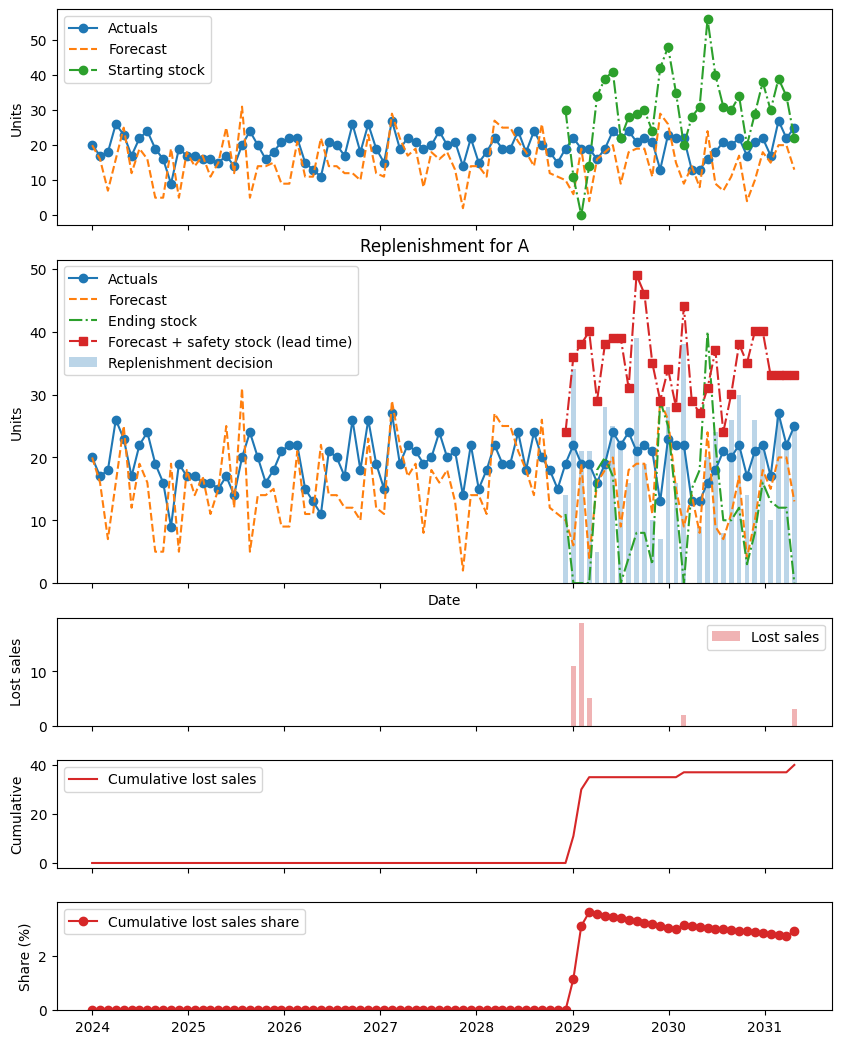

In [20]:
example_id = sigma_decisions_df["unique_id"].iloc[0]
plot_replenishment_decisions(rows_df, sigma_decisions_df, unique_id=example_id)


## 3) Optimize Sigma + Aggregation Window


In [21]:
candidate_windows

[3, 6, 9]

In [22]:
backtest_rmse = compute_backtest_rmse_by_article(backtest_rows)

point_configs = build_point_forecast_article_configs_from_standard_rows(
    backtest_rows,
    service_level_factor=.95,
    service_level_mode="service_level",
    fixed_rmse=backtest_rmse,
)

agg_sigma_result = optimize_aggregation_and_service_level_factors(
    point_configs,
    candidate_windows=candidate_windows,
    candidate_factors=candidate_service_levels,
    service_level_mode="service_level",
)
agg_best_factors = {
    unique_id: result.service_level_factor
    for unique_id, result in agg_sigma_result.items()
}
agg_windows = {
    unique_id: result.window
    for unique_id, result in agg_sigma_result.items()
}

agg_backtest_rmse = compute_backtest_rmse_by_article(
    backtest_rows,
    aggregation_window=agg_windows,
)

forecast_point_configs = build_point_forecast_article_configs_from_standard_rows(
    evaluation_rows,
    service_level_factor=agg_best_factors,
    service_level_mode="service_level",
    fixed_rmse=agg_backtest_rmse,
    actuals_override=backtest_actuals,
)
agg_simulations = {
    unique_id: simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=config.policy,
        aggregation_window=agg_windows[unique_id],
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )
    for unique_id, config in forecast_point_configs.items()
}
agg_decisions = build_replenishment_decisions_from_simulations(
    evaluation_rows,
    agg_simulations,
    aggregation_window=agg_windows,
    sigma=agg_best_factors,
    fixed_rmse=agg_backtest_rmse,
    service_level_mode="service_level",
)


In [23]:
agg_decisions_df = replenishment_decision_rows_to_dataframe(agg_decisions)
agg_decisions_df.head()


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,incoming_stock,starting_stock,ending_stock,safety_stock,starting_on_hand,ending_on_hand,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2028-12-05,74,19,11.666667,24.333333,0,30,11,11.58735,30,11,11,74,0,0,0.62,3,None
1,A,2029-01-04,0,22,9.666667,27.666667,0,11,0,11.58735,11,0,0,74,11,11,0.62,3,None
2,A,2029-02-03,0,19,13.000000,28.666667,0,0,0,11.58735,0,0,0,74,30,19,0.62,3,None
3,A,2029-03-05,72,19,12.666667,28.333333,74,74,55,11.58735,44,25,55,72,0,0,0.62,3,None
4,A,2029-04-04,0,16,18.000000,33.333333,0,55,39,11.58735,25,9,39,72,0,0,0.62,3,None


0      0
1     11
2     19
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
Name: missed_sales, dtype: int64


<Axes: title={'center': 'Replenishment for A'}, xlabel='Date', ylabel='Units'>

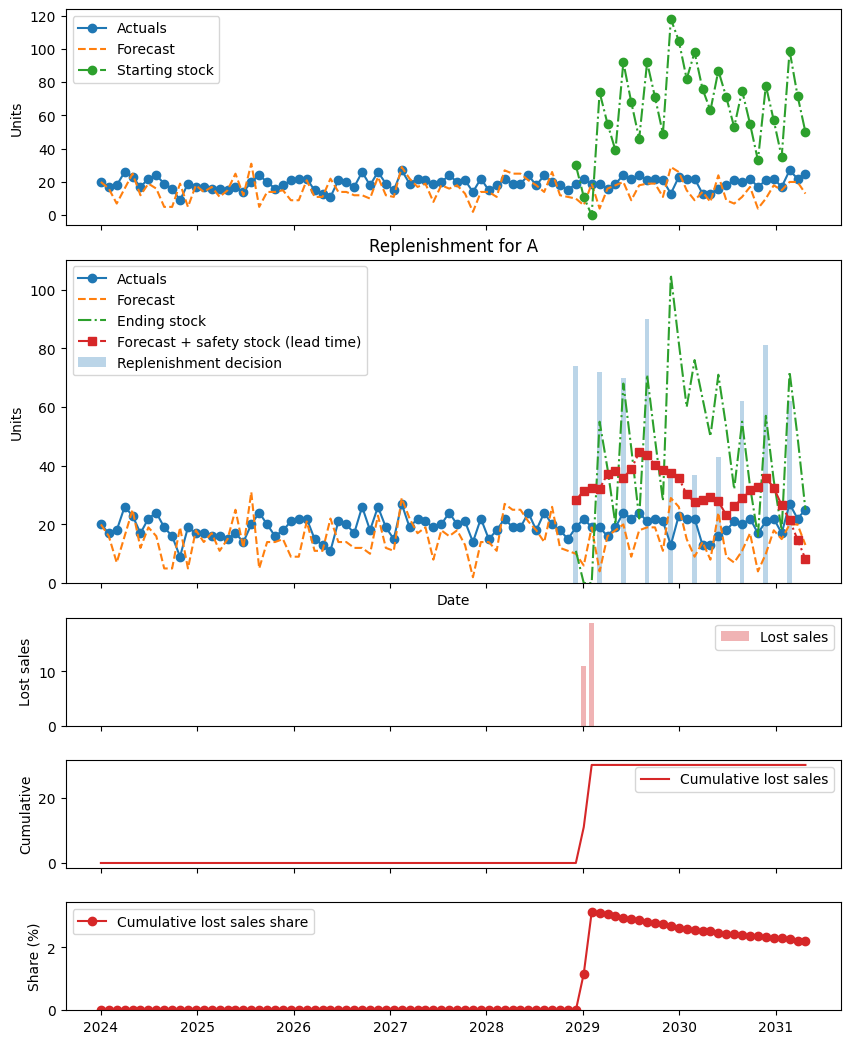

In [24]:
example_id = agg_decisions_df["unique_id"].iloc[0]
plot_replenishment_decisions(rows_df, agg_decisions_df, unique_id=example_id)


### Take a given service level and optimize aggregation windows

In [31]:
backtest_rmse = compute_backtest_rmse_by_article(backtest_rows)

point_configs = build_point_forecast_article_configs_from_standard_rows(
    backtest_rows,
    service_level_factor=.99,
    service_level_mode="service_level",
    fixed_rmse=backtest_rmse,
)

agg_sigma_result = optimize_aggregation_and_service_level_factors(
    point_configs,
    candidate_windows=candidate_windows,
    candidate_factors=candidate_service_levels,
    service_level_mode="service_level",
)
agg_best_factors = {
    unique_id: result.service_level_factor
    for unique_id, result in agg_sigma_result.items()
}
agg_windows = {
    unique_id: result.window
    for unique_id, result in agg_sigma_result.items()
}

agg_backtest_rmse = compute_backtest_rmse_by_article(
    backtest_rows,
    aggregation_window=agg_windows,
)

forecast_point_configs = build_point_forecast_article_configs_from_standard_rows(
    evaluation_rows,
    service_level_factor=agg_best_factors,
    service_level_mode="service_level",
    fixed_rmse=agg_backtest_rmse,
    actuals_override=backtest_actuals,
)
agg_simulations = {
    unique_id: simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=config.policy,
        aggregation_window=agg_windows[unique_id],
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )
    for unique_id, config in forecast_point_configs.items()
}
agg_decisions = build_replenishment_decisions_from_simulations(
    evaluation_rows,
    agg_simulations,
    aggregation_window=agg_windows,
    sigma=agg_best_factors,
    fixed_rmse=agg_backtest_rmse,
    service_level_mode="service_level",
)


0      0
1     11
2     19
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
Name: missed_sales, dtype: int64


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,incoming_stock,starting_stock,ending_stock,safety_stock,starting_on_hand,ending_on_hand,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2028-12-05,74,19,11.666667,24.333333,0,30,11,11.58735,30,11,11,74,0,0,0.62,3,None
1,A,2029-01-04,0,22,9.666667,27.666667,0,11,0,11.58735,11,0,0,74,11,11,0.62,3,None
2,A,2029-02-03,0,19,13.000000,28.666667,0,0,0,11.58735,0,0,0,74,30,19,0.62,3,None
3,A,2029-03-05,72,19,12.666667,28.333333,74,74,55,11.58735,44,25,55,72,0,0,0.62,3,None
4,A,2029-04-04,0,16,18.000000,33.333333,0,55,39,11.58735,25,9,39,72,0,0,0.62,3,None


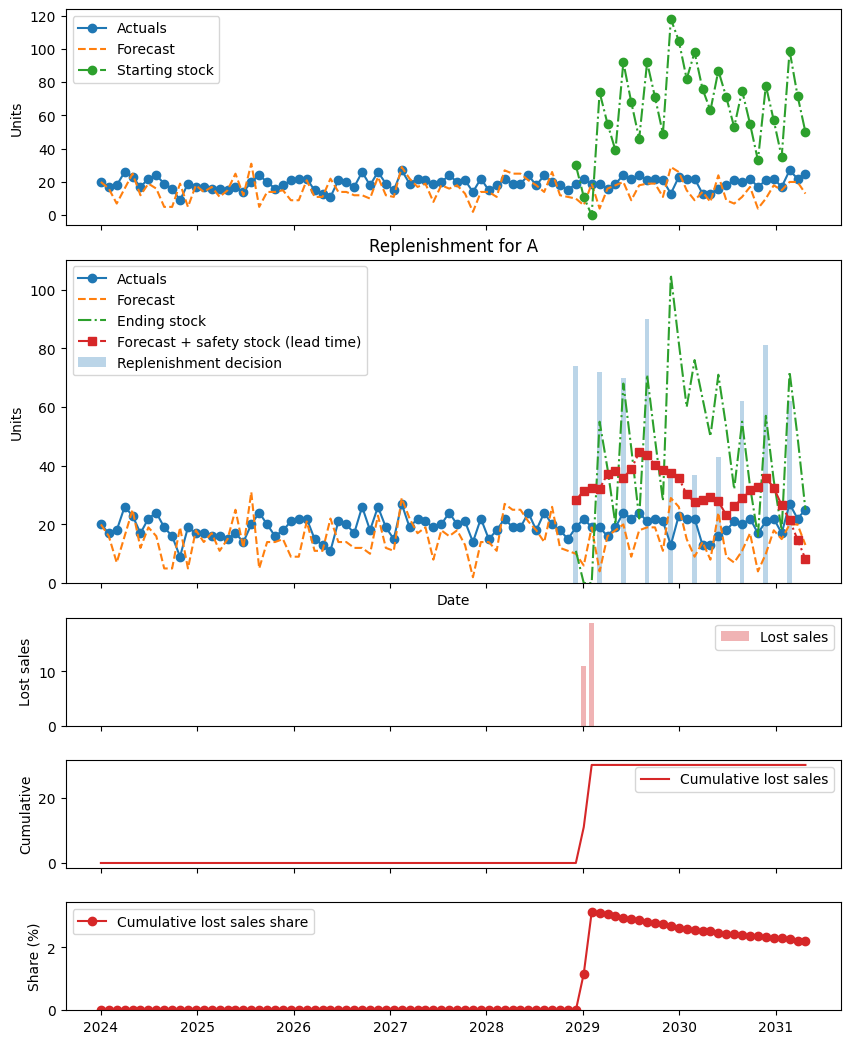

In [32]:
agg_decisions_df = replenishment_decision_rows_to_dataframe(agg_decisions)

example_id = agg_decisions_df["unique_id"].iloc[0]
plot_replenishment_decisions(rows_df, agg_decisions_df, unique_id=example_id)

agg_decisions_df.head()

In [33]:
agg_decisions_df[agg_decisions_df.ds > '2026-06-19']['missed_sales'].sum()

np.int64(6091)

In [34]:
agg_decisions_df[agg_decisions_df.ds > '2026-06-19']['demand'].sum()

np.int64(120191)

In [35]:
77 / 116312

0.0006620125180548869

0      0
1     11
2     19
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
Name: missed_sales, dtype: int64


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,incoming_stock,starting_stock,ending_stock,safety_stock,starting_on_hand,ending_on_hand,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2028-12-05,74,19,11.666667,24.333333,0,30,11,11.58735,30,11,11,74,0,0,0.62,3,None
1,A,2029-01-04,0,22,9.666667,27.666667,0,11,0,11.58735,11,0,0,74,11,11,0.62,3,None
2,A,2029-02-03,0,19,13.000000,28.666667,0,0,0,11.58735,0,0,0,74,30,19,0.62,3,None
3,A,2029-03-05,72,19,12.666667,28.333333,74,74,55,11.58735,44,25,55,72,0,0,0.62,3,None
4,A,2029-04-04,0,16,18.000000,33.333333,0,55,39,11.58735,25,9,39,72,0,0,0.62,3,None


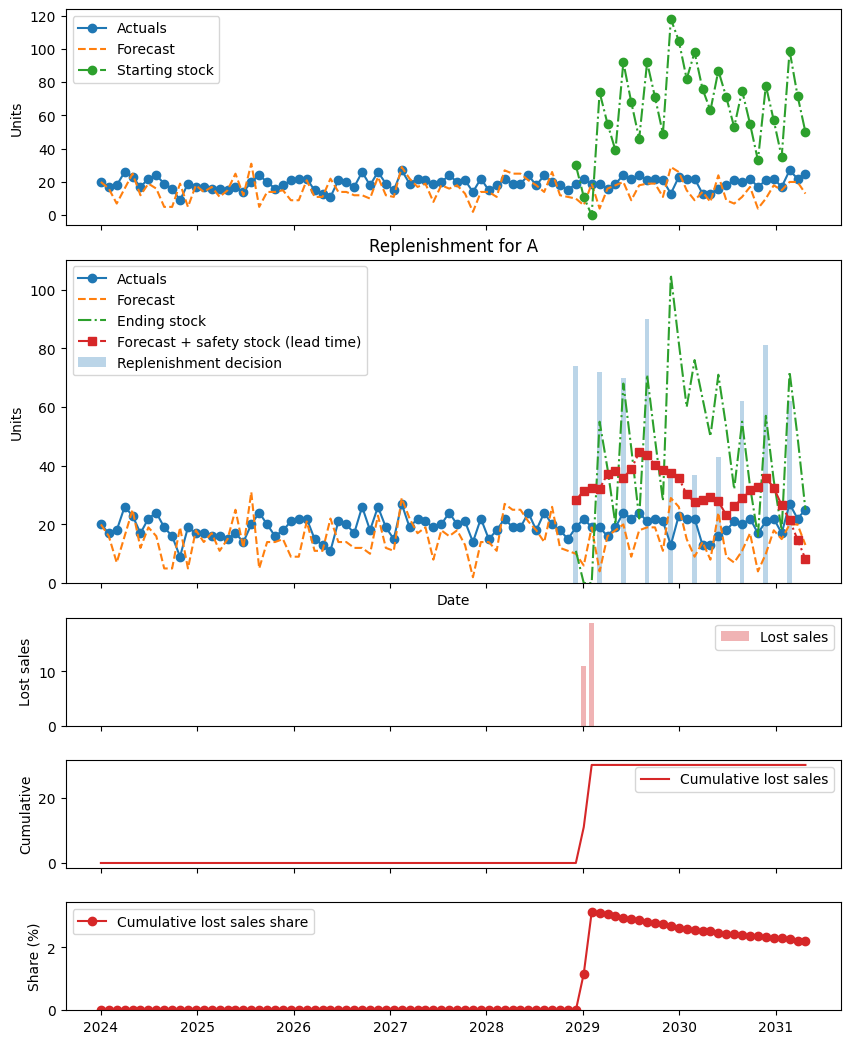

In [36]:
agg_decisions_df = replenishment_decision_rows_to_dataframe(agg_decisions)

example_id = agg_decisions_df["unique_id"].iloc[0]
plot_replenishment_decisions(rows_df, agg_decisions_df, unique_id=example_id)

agg_decisions_df.head()